# Menyeimbangkan Data menggunakan SMOTE  
Berikut langkah-langkah nya 

### Impor Library dan Koneksi Database  
Pada langkah pertama ini, kita akan mengimpor semua library yang dibutuhkan untuk analisis, mulai dari koneksi database hingga visualisasi. Kredensial database dimuat secara aman dari file .env untuk menghindari menuliskannya langsung di dalam kode.

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables
load_dotenv()

# PostgreSQL credentials
user_postgres = os.getenv("USER_POSTGRES")
password_postgres = os.getenv("PASS_POSTGRES")
host_postgres = os.getenv("HOST_POSTGRES")
port_postgres = os.getenv("PORT_POSTGRES")
db_postgres = os.getenv("DB_POSTGRES")

# MySQL credentials
user_mysql = os.getenv("USER_MYSQL")
password_mysql = os.getenv("PASS_MYSQL")
host_mysql = os.getenv("HOST_MYSQL")
port_mysql = os.getenv("PORT_MYSQL")
db_mysql = os.getenv("DB_MYSQL")

# Connections
postgres_conn = f"postgresql+psycopg2://{user_postgres}:{password_postgres}@{host_postgres}:{port_postgres}/{db_postgres}"
mysql_conn = f"mysql+pymysql://{user_mysql}:{password_mysql}@{host_mysql}:{port_mysql}/{db_mysql}"

postgres_engine = create_engine(postgres_conn)
mysql_engine = create_engine(mysql_conn)

### Mengambil Data dari Database  
Setelah koneksi berhasil dibuat, kita akan mengambil data dari tabel iris_coba pada masing-masing database (MySQL dan PostgreSQL) dan memuatnya ke dalam DataFrame pandas.

In [2]:
mysql_df_iris = pd.read_sql("SELECT * FROM iris_coba", mysql_engine.connect())
postgres_df_iris = pd.read_sql("SELECT * FROM iris_coba", postgres_engine.connect())


### Visualisasi Data Awal (Sebelum SMOTE)  
Sebelum melakukan penyeimbangan, penting untuk memahami kondisi awal data. Di sini, saya akan memvisualisasikan data menggunakan PCA dan LDA untuk melihat sebaran kelasnya. 

In [3]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# --- Gunakan dataframe dari database kamu ---
df = mysql_df_iris   # bisa juga ganti ke postgres_df_iris

# --- Cek nama kolom ---
print("Kolom dataset:", df.columns)

# --- Ambil fitur dan target ---
X_db = df[['sepal length', 'sepal width', 'petal length', 'petal width']].values
y_db = df['Class'].values   # target ada di kolom 'Class'

# --- Mapping label ke angka ---
species_mapping = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
y_numeric = np.array([species_mapping[s] for s in y_db])
target_names_db = list(species_mapping.keys())

# --- PCA (2 dimensi) ---
pca_db = PCA(n_components=2)
X_r_db = pca_db.fit(X_db).transform(X_db)

# --- LDA (2 dimensi) ---
lda_db = LinearDiscriminantAnalysis(n_components=2)
X_r2_db = lda_db.fit(X_db, y_numeric).transform(X_db)

# === Visualisasi ===
plt.figure(figsize=(15, 5))

# ---- Plot PCA ----
plt.subplot(1, 3, 1)
colors = ["navy", "turquoise", "darkorange"]
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r_db[mask, 0], X_r_db[mask, 1],
                color=color, alpha=0.8,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA - Data dari Database\n(Ketidakseimbangan Kelas)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# ---- Plot LDA ----
plt.subplot(1, 3, 2)
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r2_db[mask, 0], X_r2_db[mask, 1],
                color=color, alpha=0.8,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA - Data dari Database\n(Ketidakseimbangan Kelas)")
plt.xlabel("LD1")
plt.ylabel("LD2")

# ---- Plot distribusi kelas ----
plt.subplot(1, 3, 3)
species_counts = df['Class'].value_counts()
plt.bar(species_counts.index, species_counts.values,
        color=['navy', 'turquoise', 'darkorange'])
plt.title("Distribusi Kelas dalam Database")
plt.xlabel("Species")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
for i, v in enumerate(species_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nExplained variance ratio (database): {pca_db.explained_variance_ratio_}")


ModuleNotFoundError: No module named 'sklearn'

### Visualisasi Perbandingan Hasil SMOTE

Ini adalah langkah akhir untuk memverifikasi hasil. Kita akan membuat visualisasi perbandingan *side-by-side* menggunakan PCA untuk menunjukkan perbedaan sebaran data sebelum dan sesudah penerapan SMOTE, sekaligus membuktikan bahwa data kini telah seimbang.

In [4]:
# Ambil DataFrame dari langkah sebelumnya
df = mysql_df_iris

# Pilih HANYA kolom fitur yang relevan, buang 'id' dan 'Class'
X_features = df[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_target = df['Class']

# Mapping label string ke angka untuk model
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y_numeric = np.array([species_mapping[s] for s in y_target])

In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# ===============================
# 1. Menerapkan SMOTE
# ===============================
print("Distribusi kelas sebelum SMOTE:")
print(Counter(y_numeric))

# Inisialisasi SMOTE dengan random_state untuk hasil yang konsisten
smote = SMOTE(random_state=42)

# PENYESUAIAN: Menggunakan variabel X_features dan y_numeric yang sudah disiapkan
X_res, y_res = smote.fit_resample(X_features, y_numeric)

print("\nDistribusi kelas setelah SMOTE:")
print(Counter(y_res))
print(f"Total sampel setelah SMOTE: {len(y_res)}")


# ===============================
# 2. Membuat DataFrame Baru dari Hasil SMOTE
# ===============================
# Gabungkan fitur dan target yang sudah diseimbangkan
df_resampled = pd.DataFrame(X_res, columns=X_features.columns)

# PENYESUAIAN: Mapping kembali label numerik (0,1,2) ke nama kelas (string) untuk keterbacaan
# Buat mapping terbalik dari species_mapping sebelumnya
inv_species_mapping = {v: k for k, v in species_mapping.items()}
df_resampled['Class'] = pd.Series(y_res).map(inv_species_mapping)


print("\nContoh data sintetis yang dihasilkan SMOTE:")
# Tampilkan 10 baris terakhir, yang kemungkinan besar adalah data baru
print(df_resampled.tail(10))

Distribusi kelas sebelum SMOTE:
Counter({1: 50, 2: 50, 0: 15})

Distribusi kelas setelah SMOTE:
Counter({0: 50, 1: 50, 2: 50})
Total sampel setelah SMOTE: 150

Contoh data sintetis yang dihasilkan SMOTE:
     sepal length  sepal width  petal length  petal width        Class
140      4.965308     3.197962      1.500000     0.132654  Iris-setosa
141      4.485911     3.085911      1.342956     0.200000  Iris-setosa
142      4.495833     3.095833      1.347917     0.200000  Iris-setosa
143      5.003883     3.511648      1.611648     0.592234  Iris-setosa
144      4.431093     3.031093      1.315547     0.200000  Iris-setosa
145      4.874732     3.074732      1.474732     0.150536  Iris-setosa
146      4.584123     3.000000      1.346031     0.246031  Iris-setosa
147      4.776025     3.141325      1.458675     0.141325  Iris-setosa
148      4.903474     3.103474      1.489577     0.103474  Iris-setosa
149      4.860703     3.060703      1.460703     0.178593  Iris-setosa


### Visualisasi Perbandingan Distribusi Kelas  
Untuk membuktikan bahwa proses SMOTE berhasil, pada langkah ini kita membuat visualisasi perbandingan. Diagram batang di sebelah kiri menunjukkan distribusi kelas yang tidak seimbang (sebelum), sedangkan diagram di sebelah kanan menunjukkan bahwa semua kelas kini memiliki jumlah sampel yang sama (setelah). Tabel di bawahnya merangkum hasil ini secara numerik untuk memberikan bukti yang jelas.


=== VISUALISASI HASIL SMOTE ===


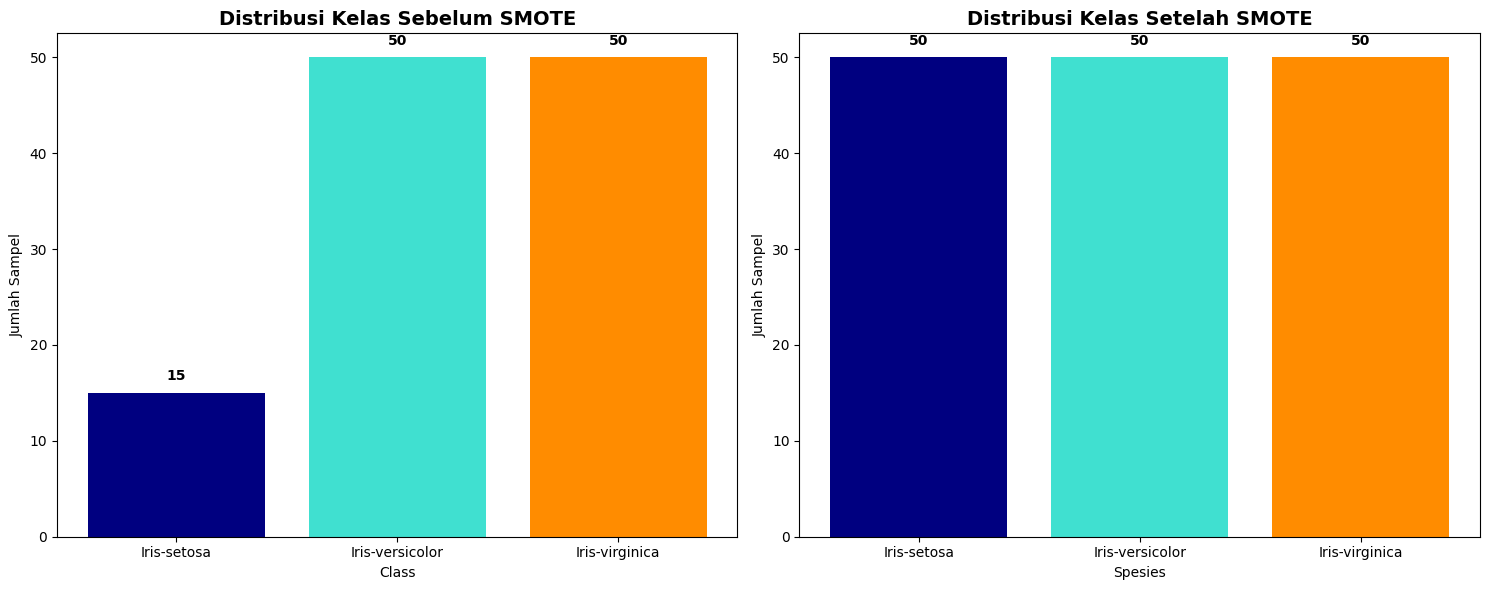


Tabel Perbandingan:
           Spesies  Sebelum SMOTE  Setelah SMOTE  Sampel Sintetis Ditambahkan
0      Iris-setosa             15             50                           35
1  Iris-versicolor             50             50                            0
2   Iris-virginica             50             50                            0


In [6]:
# Visualisasi perbandingan data sebelum dan sesudah SMOTE
print("\n=== VISUALISASI HASIL SMOTE ===")

# Buat subplot untuk perbandingan
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PERBAIKAN: Definisikan 'target_names' di sini agar variabel selalu tersedia.
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

# Plot distribusi kelas sebelum SMOTE
before_counts = Counter(y_numeric)
sorted_before_items = sorted(before_counts.items())
species_indices = [item[0] for item in sorted_before_items]
before_values = [item[1] for item in sorted_before_items]

bars1 = axes[0].bar(species_indices, before_values, color=['navy', 'turquoise', 'darkorange'])
axes[0].set_title('Distribusi Kelas Sebelum SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].set_xlabel('Class')
axes[0].set_xticks(species_indices)
axes[0].set_xticklabels(target_names) # Sekarang variabel ini sudah ada

# Tambahkan label nilai di atas bar
for bar, value in zip(bars1, before_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(value), ha='center', va='bottom', fontweight='bold')

# Plot distribusi kelas setelah SMOTE
after_counts = Counter(y_res)
sorted_after_items = sorted(after_counts.items())
after_values = [item[1] for item in sorted_after_items]

bars2 = axes[1].bar(species_indices, after_values, color=['navy', 'turquoise', 'darkorange'])
axes[1].set_title('Distribusi Kelas Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Jumlah Sampel')
axes[1].set_xlabel('Spesies')
axes[1].set_xticks(species_indices)
axes[1].set_xticklabels(target_names) # Sekarang variabel ini sudah ada

# Tambahkan label nilai di atas bar
for bar, value in zip(bars2, after_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Tabel perbandingan
print("\nTabel Perbandingan:")
comparison_df = pd.DataFrame({
    'Spesies': target_names,
    'Sebelum SMOTE': before_values,
    'Setelah SMOTE': after_values,
    'Sampel Sintetis Ditambahkan': [after_values[i] - before_values[i] for i in range(len(target_names))]
})
print(comparison_df)

### Penerapan SMOTE dan Visualisasi Perbandingan Hasil  
Ini adalah sel kode utama yang menjalankan keseluruhan proses. Pertama, kita mempersiapkan data dengan memilih hanya 4 kolom fitur yang relevan (membuang 'id'). Kemudian, kita menerapkan SMOTE untuk menyeimbangkan jumlah sampel di setiap kelas. Terakhir, kita menggunakan PCA untuk memvisualisasikan data dalam 2D, membandingkan kondisi sebelum dan sesudah SMOTE untuk membuktikan keberhasilan proses penyeimbangan.

Distribusi sebelum SMOTE: Counter({1: 50, 2: 50, 0: 15})
Distribusi setelah SMOTE: Counter({0: 50, 1: 50, 2: 50})




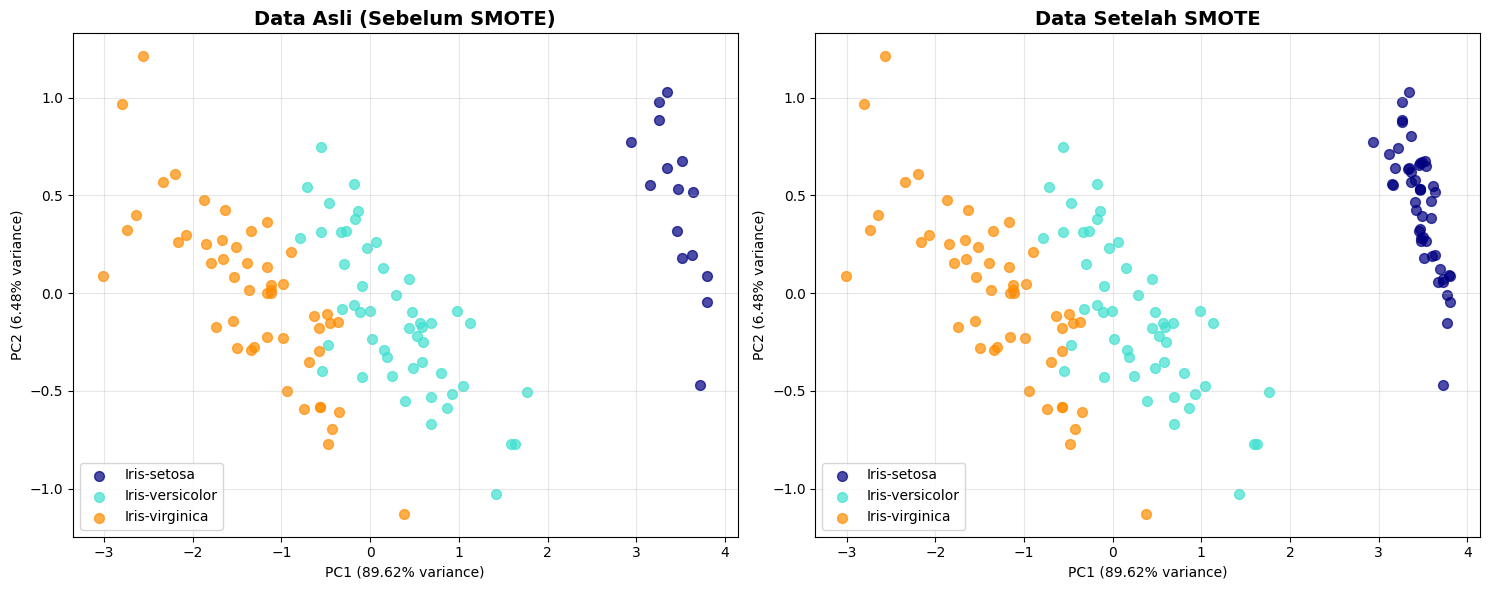

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 1. PERBAIKAN: Persiapan Fitur dan Target yang Benar
# ===============================
# Ambil DataFrame dari langkah sebelumnya
df = mysql_df_iris

# Pilih HANYA kolom fitur yang relevan, buang 'id' dan 'Class'
X_features = df[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_target = df['Class']

# Mapping label string ke angka untuk model
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y_numeric = np.array([species_mapping[s] for s in y_target])
target_names = list(species_mapping.keys())

# ===============================
# 2. Terapkan SMOTE
# ===============================
print("Distribusi sebelum SMOTE:", Counter(y_numeric))

smote = SMOTE(random_state=42)
# Gunakan X_features (tanpa 'id') dan y_numeric untuk SMOTE
X_res, y_res = smote.fit_resample(X_features, y_numeric)

print("Distribusi setelah SMOTE:", Counter(y_res))
print("\n") # Memberi spasi sebelum plot

# ===============================
# 3. PCA untuk visualisasi 2D
# ===============================
pca = PCA(n_components=2)
# Latih PCA pada data fitur asli
X_pca_before = pca.fit_transform(X_features)
# Gunakan PCA yang sama untuk mentransformasi data setelah SMOTE
X_pca_after = pca.transform(X_res)

# ===============================
# 4. Visualisasi Perbandingan
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ['navy', 'turquoise', 'darkorange']

# --- Plot data asli (sebelum SMOTE) ---
for i, (color, label) in enumerate(zip(colors, target_names)):
    mask = y_numeric == i
    axes[0].scatter(X_pca_before[mask, 0], X_pca_before[mask, 1],
                   c=color, label=label, alpha=0.7, s=50)
axes[0].set_title('Data Asli (Sebelum SMOTE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Plot data setelah SMOTE ---
for i, (color, label) in enumerate(zip(colors, target_names)):
    mask = y_res == i
    axes[1].scatter(X_pca_after[mask, 0], X_pca_after[mask, 1],
                   c=color, label=label, alpha=0.7, s=50)
axes[1].set_title('Data Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()